SSL pipeline (Barlow-Twin)

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import psutil

In [2]:
import glob
import h5py
import random

#from keras.layers.merge import add
import matplotlib.pyplot as plt
import os
import scipy

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, Tensor
import pickle

In [4]:
from CoRE_2019.MOFormer_modded.transformer import Transformer, TransformerRegressor
from CoRE_2019.MOFormer_modded.dataset_modded import MOF_ID_Dataset
from CoRE_2019.MOFormer_modded.tokenizer.mof_tokenizer import MOFTokenizer
import csv
import yaml
from CoRE_2019.MOFormer_modded.model.utils import *

/home/sartaaj/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import warnings
from CoRE_2019.CGCNN.extract import extractFeaturesCGCNN
from CoRE_2019.CGCNN.extract import collate_pool_mod
from CoRE_2019.CGCNN.cgcnn_pretrain import CrystalGraphConvNet

In [6]:
tokenizer = MOFTokenizer("CoRE_2019/MOFormer_modded/tokenizer/vocab_full.txt")
config = yaml.load(open("CoRE_2019/MOFormer_modded/config_ft_transformer.yaml", "r"), Loader=yaml.FullLoader)
config['dataloader']['randomSeed'] = 0

if torch.cuda.is_available() and config['gpu'] != 'cpu':
    device = config['gpu']
    torch.cuda.set_device(device)
    config['cuda'] = True

else:
    device = 'cpu'
    config['cuda'] = False
print("Running on:", device)

Running on: cuda:0


In [75]:
from CoRE_2019.MOFormer_modded.transformer import PositionalEncoding
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

batch_size = 64
class TransformerXRD(nn.Module):
    def __init__(self, input_features=8192, seq_length=batch_size, transformer_heads=8, transformer_ff_dim=512, mlp_hidden_dim=256):
        super(TransformerXRD, self).__init__()
        
        # Project input features to sequence length dimension
        self.input_proj = nn.Linear(input_features, seq_length)
        
        # Define a single Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=seq_length, nhead=transformer_heads, dim_feedforward=transformer_ff_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        # MLP for regression output
        self.mlp = nn.Sequential(
            nn.Linear(seq_length, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, 1)  # Output layer for regression
        )
        self.mlp_manip = nn.Sequential(
            nn.Linear(seq_length, mlp_hidden_dim)
        )
        
    def forward(self, x):
        # Project input features to sequence length dimension
        x_proj = self.input_proj(x)
        x_proj = x_proj.transpose(0, 1)
        
        # Pass through the Transformer encoder
        transformer_output = self.transformer_encoder(x_proj)
        
        # Revert to the original format (N, S) for the MLP
        transformer_output = transformer_output.transpose(0, 1)
        #print("Transformer output shape : {}".format(transformer_output.shape))
        
        # Pass through the MLP
        #output = self.mlp(transformer_output)
        
        # Squeeze the output to remove the extra dimension if the output dimension is 1 -> else, consider alternative for multi-output regression tasks; maybe make conditional?
        return transformer_output

class Transformer(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.token_encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model

        self.init_weights()

    def init_weights(self) -> None:
        # initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        nn.init.xavier_normal_(self.token_encoder.weight)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.token_encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, 0:1, :] #this was added in by me

        return output.squeeze(dim = 1) #this was added in by me
        #return output

In [76]:
transformer_SMILES = Transformer(**config['Transformer'])
transformer_XRD = TransformerXRD()

class UnifiedTransformer(nn.Module):
    def __init__(self, config, input_features=8192, seq_length=batch_size, transformer_heads=8, transformer_ff_dim=512, mlp_hidden_dim=256):
        super(UnifiedTransformer, self).__init__()
        
        # Initialize Transformer1 with its parameters
        self.transformer1 = Transformer(**config['Transformer'])
        
        # Initialize Transformer2 components
        self.transformer2 = TransformerXRD(input_features, seq_length, transformer_heads, transformer_ff_dim, mlp_hidden_dim)

        #projector
        self.proj = nn.Sequential(
            nn.Linear(576, mlp_hidden_dim), #used to be mlp_hidden_dim here instead of 576 (output size)
            nn.Softplus(),
            nn.Linear(mlp_hidden_dim, 512) #used to be mlp_hidden_dim here instead of 576 (input size)
        )
                
    def forward(self, xrd, smiles):
        transformer1_output = self.transformer1(smiles) #gets output from SMILES transformer -> shape of (batchSize, 512, 512)
        transformer2_output = self.transformer2(xrd) #gets output from XRD transformer -> shape of (batchSize, seq_len)

        # Now, concatenate tensor1 and the corrected pooled_tensor2 along the second dimension
        concatenated_tensor_corrected = torch.cat((transformer1_output, transformer2_output), dim=1)
        output = self.proj(concatenated_tensor_corrected)
        
        return output

In [9]:
with open('CoRE_2019/CGCNN/ssl_ds_graph.pickle', 'rb') as handle:
    ssl_ds_graph = pickle.load(handle)

with open('CoRE_2019/CGCNN/ssl_xrd.pickle', 'rb') as handle:
    ssl_xrd = pickle.load(handle)

with open('CoRE_2019/CGCNN/ssl_smiles.pickle', 'rb') as handle:
    ssl_smiles = pickle.load(handle)

In [77]:
data_size = len(ssl_xrd) #should give 8.5k entries for CoRE-2019
print(f'Full pretraining set size is {data_size}')
split_ratio = 0.95 #train set %
train_size = int(split_ratio * data_size)

ssl_xrd_train, ssl_smiles_train, ssl_graph_train = ssl_xrd[:train_size], ssl_smiles[:train_size], ssl_ds_graph[:train_size]
ssl_xrd_val, ssl_smiles_val, ssl_graph_val = ssl_xrd[train_size-1::], ssl_smiles[train_size-1::], ssl_ds_graph[train_size-1::]

Full pretraining set size is 133


In [78]:
model = UnifiedTransformer(config=config).to(device)

orig_atom_fea_len, nbr_fea_len = extractFeaturesCGCNN('CoRE_2019/CGCNN/00958972.2016.1253069_1472494_clean.cif').featureLengths()

config_crystal = yaml.load(open("CoRE_2019/CGCNN/config_ft_cgcnn.yaml", "r"), Loader=yaml.FullLoader) #configurations for CGCNN

config_crystal['model']['orig_atom_fea_len'] = orig_atom_fea_len
config_crystal['model']['nbr_fea_len'] = nbr_fea_len

model_g = CrystalGraphConvNet(**config_crystal['model']).to(device)

1
1
1
1


In [79]:
from SSL.barlow_twins import BarlowTwinsLoss

loss = BarlowTwinsLoss(device = device, batch_size = 64, embed_size = 512, lambd = 0.0051) #same parameters as in moformer

optimizer_g = optim.Adam(model_g.parameters(), lr = 0.00005)
optimizer_t = optim.Adam(model.parameters(), lr = 0.00005)

In [80]:
#now, test for 100 epoch?

num_epoch = 100
loss_history = []
val_history = []
n_iter = 0
valid_n_iter = 0
best_valid_loss = np.inf
norm = False #should embeddings be normalized? in crystal-twin, they don't but for barlow-twin, it's in the algorithm

for epoch in range(num_epoch):
    model_g.train()
    model.train()

    print(f'Epoch : {epoch + 1}')
    loss_ensemble = []
    for bn, (graph, xrd, smiles) in enumerate(zip(ssl_graph_train, ssl_xrd_train, ssl_smiles_train)):
        input_graph_1 = (Variable(graph[0]).to(device),
                        Variable(graph[1]).to(device),
                        Variable(graph[2]).to(device),
                        [crys_idx.to(device) for crys_idx in graph[3]])
        
        xrd = torch.tensor(xrd, dtype = torch.float).to(device)
        smiles = torch.from_numpy(smiles).to(device)
        
        z_a = model_g(*input_graph_1) #embedding from cgcnn
        z_b = model(xrd, smiles) #embedding from concat. model

        if norm == True:
            z_a_norm = (z_a - torch.mean(z_a, axis = 0))/torch.std(z_a, axis = 0)
            z_b_norm = (z_b - torch.mean(z_b, axis = 0))/torch.std(z_b, axis = 0)
        
        else:
            z_a_norm = z_a
            z_b_norm = z_b

        loss_calc = loss(z_a_norm, z_b_norm)
        loss_ensemble.append(loss_calc.item())

        optimizer_g.zero_grad()
        optimizer_t.zero_grad()

        loss_calc.backward()

        optimizer_g.step()
        optimizer_t.step()
    
    torch.cuda.empty_cache()
    val_ensemble = []

    with torch.no_grad():
        model.eval()
        model_g.eval()
        for bn, (graph, xrd, smiles) in enumerate(zip(ssl_graph_val, ssl_xrd_val, ssl_smiles_val)):
            input_graph_1 = (Variable(graph[0]).to(device),
                            Variable(graph[1]).to(device),
                            Variable(graph[2]).to(device),
                            [crys_idx.to(device) for crys_idx in graph[3]])
            
            xrd = torch.tensor(xrd, dtype = torch.float).to(device)
            smiles = torch.from_numpy(smiles).to(device)

            z_a = model_g(*input_graph_1)
            z_b = model(xrd, smiles)

            if norm == True:
                z_a_norm = (z_a - torch.mean(z_a, axis = 0))/torch.std(z_a, axis = 0)
                z_b_norm = (z_b - torch.mean(z_b, axis = 0))/torch.std(z_b, axis = 0)
            else:
                z_a_norm = z_a
                z_b_norm = z_b
            
            valid_loss = loss(z_a_norm, z_b_norm)
            val_ensemble.append(valid_loss.item())

        val_history.append(np.mean(val_ensemble))
        if np.mean(val_ensemble) < best_valid_loss:
            best_valid_loss = np.mean(val_ensemble)
            
            #save the models here?
            torch.save(model.state_dict(), os.path.join('SSL/pretrained/transformer', 'model_t.pth'))
            torch.save(model_g.state_dict(), os.path.join('SSL/pretrained/cgcnn', 'model_g.pth'))

    
    loss_history.append(np.mean(loss_ensemble))
    print(f'Ensembled Loss : {loss_history[-1]}, Val. Ensembled Loss : {val_history[-1]}')
    print('###############################')

Epoch : 1
Ensembled Loss : 391.8476298498729, Val. Ensembled Loss : 296.6166763305664
###############################
Epoch : 2
Ensembled Loss : 269.62337990412635, Val. Ensembled Loss : 236.9739933013916
###############################
Epoch : 3
Ensembled Loss : 215.10306294759116, Val. Ensembled Loss : 197.2298812866211
###############################
Epoch : 4
Ensembled Loss : 187.37942165798611, Val. Ensembled Loss : 176.4807014465332
###############################
Epoch : 5
Ensembled Loss : 169.45048280746218, Val. Ensembled Loss : 160.79550552368164
###############################
Epoch : 6
Ensembled Loss : 152.8185545906188, Val. Ensembled Loss : 147.6320915222168
###############################
Epoch : 7
Ensembled Loss : 139.29761008610802, Val. Ensembled Loss : 134.2743101119995
###############################
Epoch : 8
Ensembled Loss : 127.59053493681408, Val. Ensembled Loss : 123.25258541107178
###############################
Epoch : 9
Ensembled Loss : 119.38490440731957, V

In [44]:
#saves transformer
torch.save(model, os.path.join('SSL/pretrained/transformer', f'pretrained_weights_{num_epoch}_{norm}.pth'))

#saves CGCNN
torch.save(model_g, os.path.join('SSL/pretrained/cgcnn', f'cgcnn_{num_epoch}_{norm}_weights.pth'))

In [45]:
#save loaded_dict state
torch.save(model.state_dict(), os.path.join('SSL/pretrained/transformer', f'pretrained_dict_{num_epoch}_{norm}.pth'))

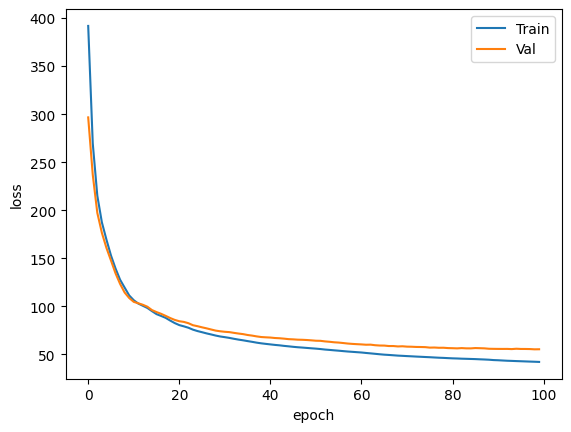

In [81]:
plt.plot(loss_history, label = 'Train')
plt.plot(val_history, label = 'Val')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(loc = 'upper right')
plt.savefig(os.path.join('SSL/figures', f'SSL_learning_curve_{num_epoch}_{norm}.png'))

In [ ]:
#not really learning - why? maybe compare to MOFormer and see how much their loss decreased by.
#edit: issue fixed, initially set learning rate -> 0.0051 but it was too high (must have gotten stuck in a local minima somewhere) - it is learning now.